In [1]:
import scqubits as scq
import scipy as sp
import numpy as np

# User-defined Diagonalization

Often the most time consumuing operation that `scqubits` performs is a diagonalization of the system Hamiltonian when the `eigensys` or . `scqubits` allows users to sepcify what library or procedure is used, if something other than the default method (typically provided via the `scipy` library) is desired. 

Such customization is done by setting `esys_method` and `evals_method` (and potentially `esys_method_options` and `evals_method_options` to further customize diagonalization options) of the different quantum system classes (which can be done at object initialization time, or alternatively, after the object has already been created). 

Further more, `esys_method` and `evals_method` can be either:
1. A string that `scqubits` maps to a predefined diagonalization function, with some particular set of preset options. 
2. An arbitrary, user-defined callable object (e.g., a function) that can perform the diagonalization.

Parameters `esys_method_options` and `evals_method_options` can be also set, if the user wishes to pass custom options to the diagonalization routines defined by `esys_method` and `evals_method` respectively. Setting these is a powerful way to easily customize how the diagonalization is performed. 


## Predefined procedures

In the case of scenario (1) above, users can check all the predefined diagonalization procedures that have a string-representation by listing the keys of the `DIAG_METHODS` dictionary:

In [2]:
print(*scq.DIAG_METHODS.keys(), sep="\n")

evals_scipy_dense
esys_scipy_dense
evals_scipy_sparse
esys_scipy_sparse
evals_scipy_sparse_SM
esys_scipy_sparse_SM
evals_scipy_sparse_LA_shift-inverse
esys_scipy_sparse_LA_shift-inverse
evals_scipy_sparse_LM_shift-inverse
esys_scipy_sparse_LM_shift-inverse
evals_primme_sparse
esys_primme_sparse
evals_primme_sparse_SM
esys_primme_sparse_SM
evals_primme_sparse_LA_shift-inverse
esys_primme_sparse_LA_shift-inverse
evals_primme_sparse_LM_shift-inverse
esys_primme_sparse_LM_shift-inverse
evals_cupy_dense
esys_cupy_dense
evals_cupy_sparse
esys_cupy_sparse


In the above, the first part of the string represents whether just the eigenvalues or both eigenvalues and eigenvectors are returned. Naturally, procedures that return the eigenvalues (eigenvalues **and** eigenvectors) are used by the method `eigenvals` (`eigensys`) of the different quantum objects that `scqubits` implements. 
The second word labels what library is used (e.g., `scipy` or `cuda`, etc.), and the third, whether sparse or dense diagonalization should be performed. Everything that follows, is simply some description of specific diagonalization options that are used.

For example, a method `esys_cupy_sparse` will invoke the diagonalization function [eigsh](https://docs.cupy.dev/en/stable/reference/generated/cupyx.scipy.sparse.linalg.eigsh.html) from the sparse implemetnation of the cupy library (see [here](https://docs.cupy.dev/en/stable/reference/scipy_sparse_linalg.html)), which will return the lowest set of requested eigenvalues and eigenvectors (i.e., will have the options `which='SA'` passed in).

On the other hand, setting `esys_method` to `"esys_scipy_sparse_LA_shift-inverse"`, while instantiating a quantum system object (e.g., a `Transmon`), when `Transmon.eigensys` method is called, `scqubits` will call internally invoke the `scipy`'s sparse diagonalization routine (here `eighs`). Furthermore, the shift-inverse method will be used, while algebraic (and not by magnitude) eienvalue ordering is used (i.e., `which='LA'` will be passed to `eighs` - see `scipy`'s documnetation for more details). 

.. note::
It is crucial to note that in some cases, a particular method may be the wrong choice. For example in quantum systems where the eigenenergies are not guaranteed to be positive, using the "SM" method (that sorts eigenvalues by magnitude), may lead to incorrect results.

`scqubits` supports a number of backend libraries such as, 
[scipy](https://docs.scipy.org/doc/scipy/tutorial/index.html),
[primme](https://www.cs.wm.edu/~andreas/software/doc/apieigs.html),
[cupy](https://cupy.dev/) (which allows for GPU-based diagonalization).

.. note::
    Some of the libraries that can be used for diagonalization (e.g., [cupy](https://cupy.dev/) or [primme](https://www.cs.wm.edu/~andreas/software/doc/apieigs.html)) are only optional depedenecies of `scqubits`.
    Naturally, however, they do need to be installed before a digonalization method that relies on them is selected. 



As an example, let us consider a fluxonium qubit with a custom diagonalization method (and options set by providing a dictionary to `evals_method_options`), that take advante of the sparase diagonalization routine provided by the [primme](https://www.cs.wm.edu/~andreas/software/doc/apieigs.html) library. 

In [3]:
fluxonium= scq.Fluxonium(EJ=8.9, EC=2.5, EL=0.5, flux = 0.5, cutoff = 120,
                        evals_method='evals_primme_sparse', 
                        evals_method_options=dict(tol=1e-4))

evals = fluxonium.eigenvals()

We can compare the eigenvalues obtained useing the [primme](https://www.cs.wm.edu/~andreas/software/doc/apieigs.html) to the default `scqubits` method (by resettting `evals_method` and `evals_method_options` to `None`)

In [4]:
fluxonium.evals_method = None
fluxonium.evals_method_options = None

evals_default = fluxonium.eigenvals()
print(evals_default)

[-0.63001146 -0.26659009  8.75633751 11.69881054 16.67252211 17.42908833]


Comparing the two approaches shows the same results

In [5]:
np.allclose(evals, evals_default)

True

.. note::
    In the future version of `scqubits` one will be able to optionally also retrieve metadata
    about the diagonalization process that is often available to the user by the different libraries. 
   

## Custom procedures

As outlined above, the diagonalization procedures can be even further customized. This is done by, instead of passing a string-based description as `esys_method` or `evals_method`, providing a callable object (e.g., function). 
In principle this approach could be used to take advantage of 3rd party libraries (e.g., that use GPUs) that may not have yet been directly utilized in `scqubits`.
In the following trivial example, a simple user-defined function `custom_esys` (that internally calls `scipy.linalg.eigh`) is used for the diagonalization. 

In [6]:
def custom_esys(matrix, evals_count, **kwargs):  
    evals, evecs = sp.linalg.eigh(
        matrix, subset_by_index=(0, evals_count - 1), 
        eigvals_only=False,  
        **kwargs
    )
    return evals, evecs
    
tmon = scq.Transmon(EJ=30.02, EC=1.2, ng=0.0, ncut=501, 
                    esys_method=custom_esys, 
                    esys_method_options=dict(driver='evr'))

We can see what all the diagonalization related variables of `tmon` are set to - both `esys_method` and `esys_method_options` are now not `None`:

In [7]:
print(tmon.esys_method, 
      tmon.esys_method_options, 
      tmon.evals_method, 
      tmon.evals_method_options, sep="\n")

<function custom_esys at 0x7f4868389c10>
{'driver': 'evr'}
None
None


We can then diagonalize the system with a standard call to `eigensys`, which will return both the eigenvalues as well as the eigenvectors:

In [8]:
evals, evecs = tmon.eigensys()

Let us compare the above results with the default diagonalization method (which in the case of the transmon qubit is done usingg `scipy.linalg.eigvalsh_tridiagonal`):

In [9]:
tmon.esys_method = None   
tmon.esys_method_options = None  

evals_default, evecs_default = tmon.eigensys()

Comparing the eigenvalues obtained using the two procedures gives

In [10]:
np.allclose(evals, evals_default)

True

and for the eigenvecotrs:

In [11]:
print(*[np.allclose(evecs[i], evecs_default[i]) for i,_ in enumerate(evals)])

True True True True True True


## Diagonalization of composite systems

Custom diagonaliation procedure can set by the user for both, the predefined qubit classes (as shown above), but also for systems consisting of joint [Hilbert spaces]( https://scqubits.readthedocs.io/en/latest/guide/ipynb/hilbertspace.html). Since often one is intersted in a low-lying energy landscape of larger systems, `scqubits` uses the concept of hierarchical diagonalization to minimize the sice of the relevant Hilber space that has to be considered: Each system is first diagonalized separately, the coupling terms are then rewritten in the (often some subset of) repsective eigenbasis, and finally the combained sytem is diagonalized at the end. This gives a lot of control to the user, and `scqubits` allows one to set custom (and even different) diagonalization procedure for each step of this process.  

.. note::
    In the fututure version of `scqubits`, users will be also able to define their diagonalization procedure of choice, when working with [Custom circuits](https://scqubits.readthedocs.io/en/latest/guide/ipynb/custom_circuit_root.html). 

Here as an example of a joint system consisting of a Fluxonium and a Transmon qubit, where each qubit, as the combined Hamiltonian are all diagonalized using a diefferent method. 

In [12]:
tmon = scq.Transmon(EJ=30.02, EC=1.2, ng=0.0, ncut=101, ) # default diaongalization method
fluxonium= scq.Fluxonium(EJ=8.9, EC=2.5, EL=0.5, flux = 0.5, cutoff = 110,
                         evals_method='evals_primme_sparse' # use the primme library
                        )

hs = scq.HilbertSpace([tmon, fluxonium],
                     evals_method='evals_scipy_sparse' # use scipy
                     )

hs.add_interaction(
    g_strength = 0.250,
    op1 = tmon.n_operator,
    op2 = fluxonium.n_operator,
    add_hc = True
);

In [13]:
evals = hs.eigenvals(evals_count=10)

Let us reset the diagonalization methods to default, for both the `fluxonium` as well as `hs`:

In [14]:
fluxonium.evals_method=None
hs.evals_method=None

and compare the results results with those obtained above 

In [15]:
evals_default = hs.eigenvals(evals_count=10)
np.allclose(evals, evals_default)

True

Note that regardless of the (predefined) diagonalization procedure that has been used, the eivenectors that are returened are objects of the type `qutip.Qobj`, and hence remember their Hilbert space (i.e. tensor product) structure.

In [21]:
hs.esys_method='esys_primme_sparse'
evals, evecs = hs.eigensys()

In [24]:
evecs[3]

Quantum object: dims = [[6, 6], [1, 1]], shape = (36, 1), type = ket
Qobj data =
[[ 0.00000000e+00+0.00000000e+00j]
 [ 8.55413137e-05-6.99813733e-05j]
 [ 0.00000000e+00+0.00000000e+00j]
 [-7.72374643e-01+6.31879918e-01j]
 [ 0.00000000e+00+0.00000000e+00j]
 [-3.25271419e-04+2.66104641e-04j]
 [-3.92227912e-02-4.79437445e-02j]
 [ 0.00000000e+00+0.00000000e+00j]
 [ 8.53254276e-03+1.04297027e-02j]
 [ 0.00000000e+00+0.00000000e+00j]
 [ 7.63425901e-03+9.33169090e-03j]
 [ 0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j]
 [ 7.93941720e-05-6.49523948e-05j]
 [ 0.00000000e+00+0.00000000e+00j]
 [ 6.44002443e-04-5.26858583e-04j]
 [ 0.00000000e+00+0.00000000e+00j]
 [ 7.17684441e-05-5.87137850e-05j]
 [ 2.46202370e-04+3.00943997e-04j]
 [ 0.00000000e+00+0.00000000e+00j]
 [-1.55673769e-04-1.90286902e-04j]
 [ 0.00000000e+00+0.00000000e+00j]
 [-1.87766622e-04-2.29515408e-04j]
 [ 0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j]
 [-5.28872247e-06+4.32670536e-06j]
 [ 0.0000

## GPU support

Diagonalization on GPUs is currently supported through the [cupy](https://cupy.dev/) library. As the capabilities of [cupy](https://cupy.dev/) are currently somewhat limited, only dense (not sparse) operations are supported. As already outlined above, [cupy](https://cupy.dev/) (and its dependecies) have to be installed in order for this functionality to work, as show here:

It is worth pointing out, that depending on one's hardware, and the quantum system studied, the performance of GPU vs CPU diagonalization may vary dramatically from setup to setup. 


In [17]:
import cupy
cupy.__version__

'12.1.0'

In [18]:
zero_pi = scq.ZeroPi(
    grid = scq.Grid1d(-6*np.pi, 6*np.pi, 200),
    EJ   = 10.0,
    EL   = 0.04,
    ECJ  = 20.0,
    EC = 0.04,
    ng   = 0.1,
    flux = 0.23,
    ncut = 10,  #smaller than needed, for testing purposes
    esys_method='esys_cupy_dense', 
    evals_method='evals_cupy_dense', 
)

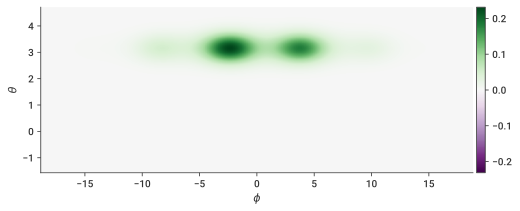

In [19]:
fig, ax = zero_pi.plot_wavefunction(which=1, mode='real', zero_calibrate=True);

Spectral data:   0%|          | 0/27 [00:00<?, ?it/s]

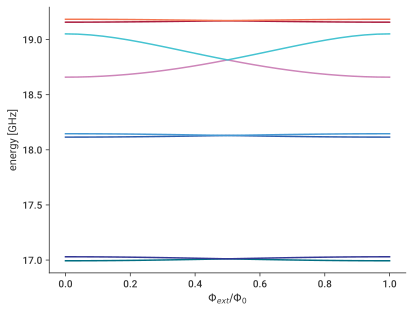

In [20]:
flux_list = np.linspace(0, 1, 27)
zero_pi.plot_evals_vs_paramvals('flux', flux_list, evals_count=8);